# PROJECT LUNG DISEASES

## REQUIREMENT

In [1]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from tensorflow.keras.layers import TimeDistributed, Bidirectional, LSTM
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG19, InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score

## DATA PREP

### Import Dataset

### Initiation Directory

In [2]:
# flow_from_directory
train = '/kaggle/input/penyakit-paru-paru-5-kelas/train_dir'
val = '/kaggle/input/penyakit-paru-paru-5-kelas/test_dir'

### Datagenerator

In [4]:
# Membuat objek ImageDataGenerator untuk augmentasi data pada set pelatihan
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Rescale nilai piksel ke rentang [0, 1]
    zoom_range=0.2 #,            # Memperbesar gambar hingga 20%
    #fill_mode='nearest'        # Mengisi piksel yang kosong dengan piksel terdekat
)

# Membuat objek ImageDataGenerator untuk preprocessing pada set pengujian dan validasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Menggunakan objek ImageDataGenerator untuk memuat data gambar dari direktori dan melakukan augmentasi
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(224, 124),
    class_mode='categorical',  # Mode kelas untuk klasifikasi banyak kelas
    batch_size = 32
)

val_generator = test_val_datagen.flow_from_directory(
    val,
    target_size=(224, 124),
    class_mode='categorical',
    batch_size = 8
)


Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


## TRAINNING W RESNET50

### Load pretrined CNN

In [5]:
# Memuat model ResNet50 tanpa layer teratas (top layer)
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 124, 3))

# Freeze the convolutional layers
for layer in resnet_model.layers:
    layer.trainable = False

94781440/94765736 [==============================] - 5s 0us/step


### Project Model

In [6]:
#Membuat model
model_resnet = Sequential()
model_resnet.add(resnet_model)
model_resnet.add(TimeDistributed(Flatten()))
model_resnet.add(Bidirectional(LSTM(128, return_sequences=True)))
model_resnet.add(Bidirectional(LSTM(16, return_sequences=True)))
model_resnet.add(Flatten())
model_resnet.add(Dense(train_generator.num_classes, activation='softmax'))

print(model_resnet.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 4, 2048)        23587712  
_________________________________________________________________
time_distributed (TimeDistri (None, 7, 8192)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 7, 256)            8520704   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 7, 32)             34944     
_________________________________________________________________
flatten_1 (Flatten)          (None, 224)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 1125      
Total params: 32,144,485
Trainable params: 8,556,773
Non-trainable params: 23,587,712
____________________________________

In [7]:
# Compile model
model_resnet.compile(optimizer=Adam(learning_rate=0.000001), loss='categorical_crossentropy', metrics=['acc'])

# Train model
history = model_resnet.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)

Epoch 1/30
190/190 [==============================] - 122s 569ms/step - loss: 1.6195 - acc: 0.1752 - val_loss: 1.6133 - val_acc: 0.2138
Epoch 2/30
190/190 [==============================] - 61s 319ms/step - loss: 1.6078 - acc: 0.2107 - val_loss: 1.6029 - val_acc: 0.2322
Epoch 3/30
190/190 [==============================] - 63s 329ms/step - loss: 1.6031 - acc: 0.2883 - val_loss: 1.5980 - val_acc: 0.3544
Epoch 4/30
190/190 [==============================] - 62s 325ms/step - loss: 1.6002 - acc: 0.3474 - val_loss: 1.5947 - val_acc: 0.4033
Epoch 5/30
190/190 [==============================] - 61s 323ms/step - loss: 1.5980 - acc: 0.3500 - val_loss: 1.5912 - val_acc: 0.4491
Epoch 6/30
190/190 [==============================] - 61s 319ms/step - loss: 1.5958 - acc: 0.3610 - val_loss: 1.5888 - val_acc: 0.4593
Epoch 7/30
190/190 [==============================] - 60s 317ms/step - loss: 1.5933 - acc: 0.3704 - val_loss: 1.5852 - val_acc: 0.4542
Epoch 8/30
190/190 [==============================] - 

model_resnet.save("resnet_model.h5")
with open('history_resnet.txt', mode='w') as file:
    file.write(str(history.history['acc'])+'/n'+str(history.history['loss']))
    file.close()

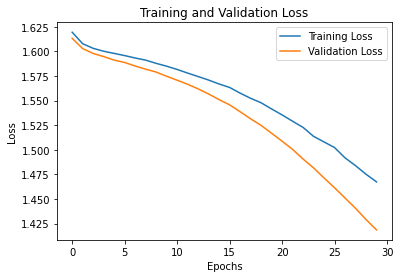

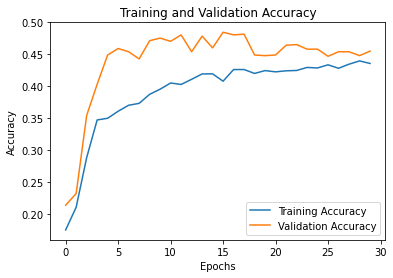

In [8]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
results = model_resnet.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

123/123 [==============================] - 6s 45ms/step - loss: 1.4186 - acc: 0.4552
Loss: 1.4185963869094849
Accuracy: 0.45519348978996277


In [10]:
train_predictions = model_resnet.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nTraining classification report:\n", train_class_report)



190/190 [==============================] - 58s 297ms/step

Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.18821   0.24344   0.21229      1220
            covid19    0.20336   0.25342   0.22564      1243
             normal    0.21038   0.23968   0.22407      1235
       tuberculosis    0.18932   0.10000   0.13087      1170
    viral_pneumonia    0.19720   0.15099   0.17103      1212

           accuracy                        0.19868      6080
          macro avg    0.19769   0.19751   0.19278      6080
       weighted avg    0.19782   0.19868   0.19352      6080



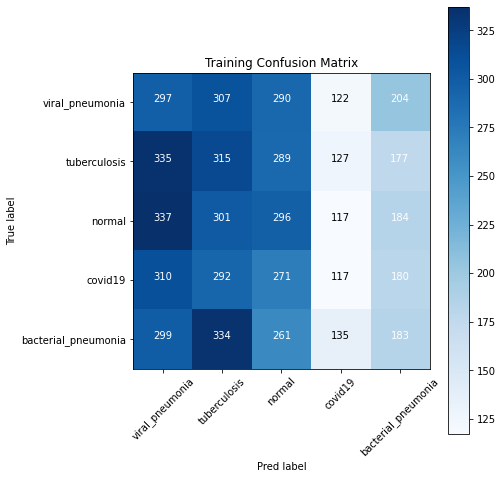

In [11]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W VGG19


### Load Pretrained CNN

In [15]:
VGG19_model =VGG19(weights='imagenet', include_top=False, input_shape=(224, 124, 3))

# Freeze the convolutional layers
for layer in VGG19_model.layers:
    layer.trainable = False

### Our Model

In [18]:
#Membuat model
model_VGG19 = Sequential()
model_VGG19.add(VGG19_model)
model_VGG19.add(TimeDistributed(Flatten()))
model_VGG19.add(Bidirectional(LSTM(128, return_sequences=True)))
model_VGG19.add(Bidirectional(LSTM(16, return_sequences=True)))
model_VGG19.add(Flatten())
model_VGG19.add(Dense(train_generator.num_classes, activation='softmax'))

print(model_VGG19.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 3, 512)         20024384  
_________________________________________________________________
time_distributed_3 (TimeDist (None, 7, 1536)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 7, 256)            1704960   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 7, 32)             34944     
_________________________________________________________________
flatten_7 (Flatten)          (None, 224)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1125      
Total params: 21,765,413
Trainable params: 1,741,029
Non-trainable params: 20,024,384
__________________________________

In [19]:
# Compile model
model_VGG19.compile(optimizer=Adam(learning_rate=0.000001), loss='categorical_crossentropy', metrics=['acc'])

# Train model
history_VGG19 = model_VGG19.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)

Epoch 1/30
190/190 [==============================] - 70s 342ms/step - loss: 1.6289 - acc: 0.2263 - val_loss: 1.6115 - val_acc: 0.2454
Epoch 2/30
190/190 [==============================] - 62s 328ms/step - loss: 1.6104 - acc: 0.2329 - val_loss: 1.5950 - val_acc: 0.2515
Epoch 3/30
190/190 [==============================] - 63s 333ms/step - loss: 1.5975 - acc: 0.2740 - val_loss: 1.5813 - val_acc: 0.3147
Epoch 4/30
190/190 [==============================] - 62s 328ms/step - loss: 1.5855 - acc: 0.3273 - val_loss: 1.5691 - val_acc: 0.3809
Epoch 5/30
190/190 [==============================] - 63s 331ms/step - loss: 1.5735 - acc: 0.3668 - val_loss: 1.5562 - val_acc: 0.4206
Epoch 6/30
190/190 [==============================] - 64s 335ms/step - loss: 1.5621 - acc: 0.4028 - val_loss: 1.5429 - val_acc: 0.4582
Epoch 7/30
190/190 [==============================] - 63s 333ms/step - loss: 1.5514 - acc: 0.4222 - val_loss: 1.5296 - val_acc: 0.4796
Epoch 8/30
190/190 [==============================] - 6

In [ ]:
model_VGG19.save("VGG19_model_skenario1.h5")
with open('history_VGG19.txt', mode='w') as file:
    file.write(str(history_VGG19.history['acc'])+'/n'+str(history_VGG19.history['loss']))
    file.close()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

  saving_api.save_model(


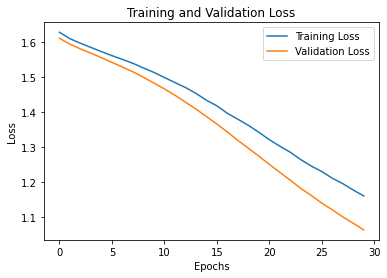

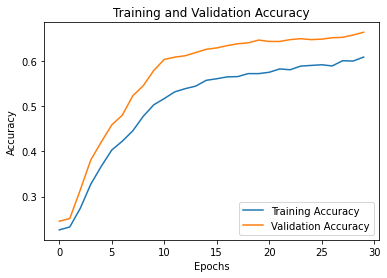

In [20]:
# Plot loss
plt.plot(history_VGG19.history['loss'], label='Training Loss')
plt.plot(history_VGG19.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_VGG19.history['acc'], label='Training Accuracy')
plt.plot(history_VGG19.history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
results = model_VGG19.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

123/123 [==============================] - 5s 42ms/step - loss: 1.0642 - acc: 0.6629
Loss: 1.0642156600952148
Accuracy: 0.662932813167572


In [22]:
train_predictions = model_VGG19.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nTraining classification report:\n", train_class_report)



190/190 [==============================] - 57s 295ms/step

Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.21579   0.13443   0.16566      1220
            covid19    0.19963   0.25905   0.22549      1243
             normal    0.18576   0.14575   0.16334      1235
       tuberculosis    0.20911   0.21966   0.21426      1170
    viral_pneumonia    0.20808   0.25908   0.23080      1212

           accuracy                        0.20345      6080
          macro avg    0.20367   0.20359   0.19991      6080
       weighted avg    0.20356   0.20345   0.19976      6080



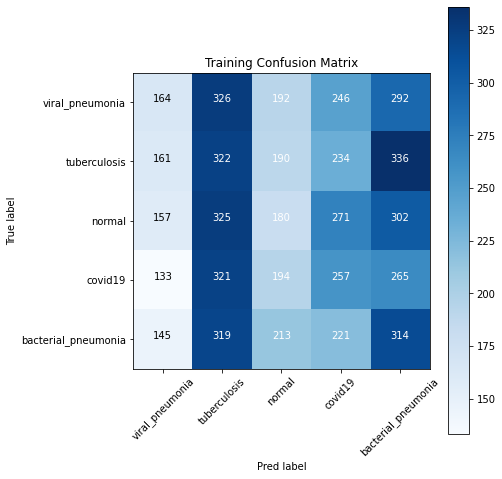

In [23]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W InceptionV3


### Load Pretrained CNN

In [25]:
InceptionV3_model = InceptionV3(weights='imagenet', 
                                include_top=False, input_shape=(224, 124, 3))
# Freeze the convolutional layers
for layer in InceptionV3_model.layers:
    layer.trainable = False

In [26]:
#Membuat model
model_InceptionV3 = Sequential()
model_InceptionV3.add(InceptionV3_model)
model_InceptionV3.add(TimeDistributed(Flatten()))
model_InceptionV3.add(Bidirectional(LSTM(128, return_sequences=True)))
model_InceptionV3.add(Bidirectional(LSTM(16, return_sequences=True)))
model_InceptionV3.add(Flatten())
model_InceptionV3.add(Dense(train_generator.num_classes, activation='softmax'))
print(model_InceptionV3.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 2, 2048)        21802784  
_________________________________________________________________
time_distributed_4 (TimeDist (None, 5, 4096)           0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 5, 256)            4326400   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 5, 32)             34944     
_________________________________________________________________
flatten_9 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 805       
Total params: 26,164,933
Trainable params: 4,362,149
Non-trainable params: 21,802,784
__________________________________

In [27]:
# Compile model
model_InceptionV3.compile(optimizer=Adam(learning_rate=0.000001), loss='categorical_crossentropy', metrics=['acc'])

# Train model
history_InceptionV3 = model_InceptionV3.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)

Epoch 1/30
190/190 [==============================] - 74s 344ms/step - loss: 1.5952 - acc: 0.2544 - val_loss: 1.5540 - val_acc: 0.3340
Epoch 2/30
190/190 [==============================] - 61s 323ms/step - loss: 1.5337 - acc: 0.3699 - val_loss: 1.4821 - val_acc: 0.4491
Epoch 3/30
190/190 [==============================] - 61s 323ms/step - loss: 1.4708 - acc: 0.4600 - val_loss: 1.4130 - val_acc: 0.5132
Epoch 4/30
190/190 [==============================] - 61s 323ms/step - loss: 1.4129 - acc: 0.5260 - val_loss: 1.3452 - val_acc: 0.5601
Epoch 5/30
190/190 [==============================] - 62s 326ms/step - loss: 1.3563 - acc: 0.5549 - val_loss: 1.2819 - val_acc: 0.5876
Epoch 6/30
190/190 [==============================] - 61s 322ms/step - loss: 1.2969 - acc: 0.5896 - val_loss: 1.2226 - val_acc: 0.6151
Epoch 7/30
190/190 [==============================] - 61s 323ms/step - loss: 1.2506 - acc: 0.6012 - val_loss: 1.1672 - val_acc: 0.6375
Epoch 8/30
190/190 [==============================] - 6

In [ ]:
model_InceptionV3.save("InceptionV3_model.h5")
with open('history_InceptionV3.txt', mode='w') as file:
    file.write(str(history_InceptionV3.history['acc'])+'/n'+str(history_InceptionV3.history['loss']))
    file.close()

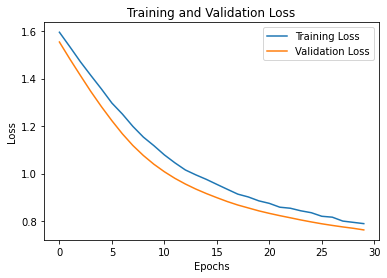

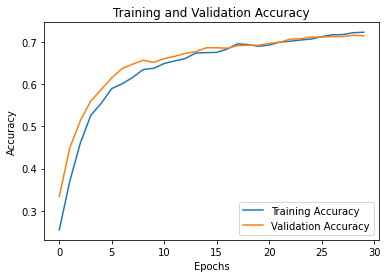

In [28]:
# Plot loss
plt.plot(history_InceptionV3.history['loss'], label='Training Loss')
plt.plot(history_InceptionV3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_InceptionV3.history['acc'], label='Training Accuracy')
plt.plot(history_InceptionV3.history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
results = model_InceptionV3.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

123/123 [==============================] - 5s 44ms/step - loss: 0.7625 - acc: 0.7149
Loss: 0.762493908405304
Accuracy: 0.7148675918579102


In [30]:
train_predictions = model_InceptionV3.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nTraining classification report:\n", train_class_report)



190/190 [==============================] - 57s 290ms/step

Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.19201   0.18525   0.18857      1220
            covid19    0.20160   0.20274   0.20217      1243
             normal    0.21232   0.21215   0.21223      1235
       tuberculosis    0.19877   0.19316   0.19593      1170
    viral_pneumonia    0.20125   0.21287   0.20690      1212

           accuracy                        0.20132      6080
          macro avg    0.20119   0.20123   0.20116      6080
       weighted avg    0.20124   0.20132   0.20122      6080



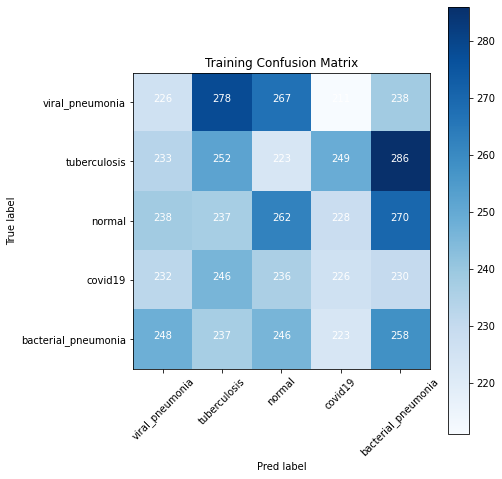

In [31]:
inp = '/kaggle/input/penyakit-paru-paru-5-kelas'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()